#### Import

In [166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pysindy as ps 
from scipy.stats import norm
from utils.print_utils import *
from utils.model_utils import *
from utils.interpol_utils import *
from utils.optimization_utils import *
from utils.data_utils import *


#### Synthetic Option

In [167]:

def black_scholes_call_time_(S,K,T,r,sigma):
    '''
    Generate the values of the black scholes equation differentiate with respect to time
    '''
    d1 = 1/(sigma*np.sqrt(T))*(np.log(S/K) + (r + (sigma**2)/2)*T)
    call_time = - K * np.exp(-r * T) * r * norm.cdf(d1  - sigma * np.sqrt(T)) - S * ((sigma)/(2*np.sqrt(T))) * norm.pdf(d1)
    return call_time

def black_scholes_call(S, X, T, r, sigma):
    '''
    Generate the price of an option through the black scholes equation
    '''
    d1 = (np.log(S / X) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / X) + (r - 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    call_price = S * norm.cdf(d1) - X * np.exp(-r * T) * norm.cdf(d2)
    return call_price

def numerical_partial_black_scholes(V,r,sigma):
    '''
    Numerical calculation of the black-scholes through DURA-MOS¸NEAGU
    '''
    N = len(V[0])
    M = len(V[:,0])
    V_dot = np.zeros([M,N])

    alpha = 0.5*(sigma**2)
    beta = 0.5*r

    #Calculate option-value
    for m in range(M):
        v_m = []
        for n in range(1,N-1):
                v_m.append((beta*n - alpha*(n**2))*V[m,n-1] + 2*(beta + alpha*(n**2))*V[m,n] - (alpha*(n**2) + beta*n)*V[m,n+1])
        V_dot[m] = [0] + v_m + [0]
    return V_dot

In [168]:
# Constants
r_ = 0.05
sigma_ = 0.4
K_ = 105
T_ = 1.

timesteps = 110
spacesteps =  110

# Monte Carlo simulation
x = np.linspace(0., K_*3, spacesteps)
t = np.linspace(0, T_, timesteps)
X, T = np.meshgrid(x, t)

dt = t[1] - t[0]
dx = x[1] - x[0]

X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T

# Calculate 'tal' using vectorized operations
tal = (np.max(t) - T)

# Calculate the call prices using vectorized operations
call_prices = black_scholes_call(X, K_, tal, r_, sigma_)

# u is the call_prices array
u = call_prices.T

u_t = black_scholes_call_time_(X, K_, tal, r_, sigma_).T[:,:-1]

C:\Users\Bruno Trotti\AppData\Local\Temp\ipykernel_4976\891614714.py:13: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(S / X) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
C:\Users\Bruno Trotti\AppData\Local\Temp\ipykernel_4976\891614714.py:13: RuntimeWarning: divide by zero encountered in true_divide
  d1 = (np.log(S / X) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
C:\Users\Bruno Trotti\AppData\Local\Temp\ipykernel_4976\891614714.py:14: RuntimeWarning: divide by zero encountered in log
  d2 = (np.log(S / X) + (r - 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
C:\Users\Bruno Trotti\AppData\Local\Temp\ipykernel_4976\891614714.py:14: RuntimeWarning: divide by zero encountered in true_divide
  d2 = (np.log(S / X) + (r - 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
C:\Users\Bruno Trotti\AppData\Local\Temp\ipykernel_4976\891614714.py:5: RuntimeWarning: divide by zero encountered in true_divide
  d1 = 1/(sigma*np.sqrt(T))*(np.log(S/K) + (r + (sigma**2)/2)*T)
C:\Us

Error for Finite Difference 
RSE 1.8765467472039965e-06
RMSE 0.7453197079071284
Error for Numerical Black-Scholes
RSE 4.597514451240606e-08
RMSE 0.11666066903841085


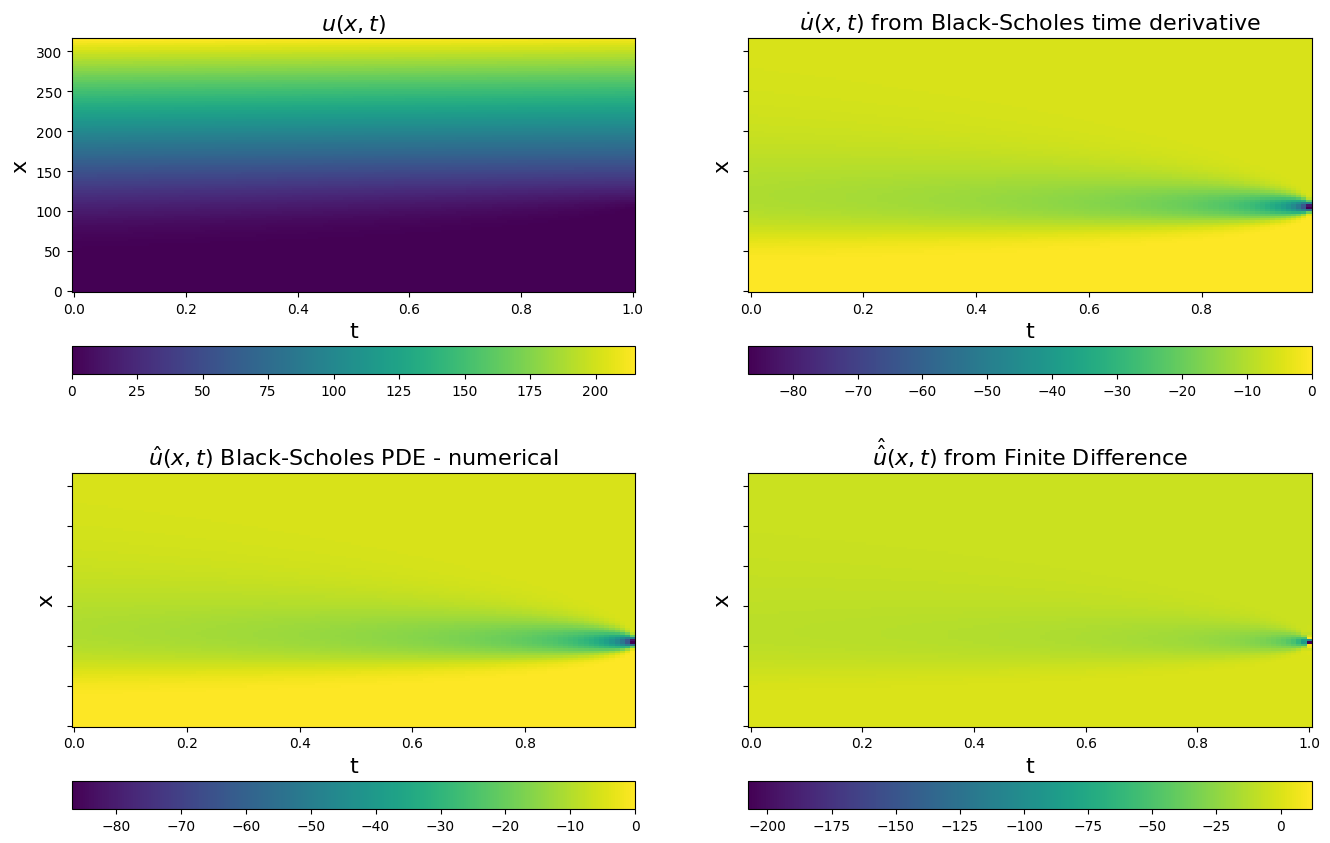

In [169]:
# n_arr = np.asarray([np.arange(0,spacesteps,1)]*timesteps).T
u_x = ps.FiniteDifference(axis=0,order = 6)._differentiate(u,t = dx)
u_xx = ps.FiniteDifference(axis=0,d=2,order = 8)._differentiate(u,t = dx)
u_t_ = ps.FiniteDifference(axis=1,order = 25)._differentiate(u,t = dt)
# v_dot = numerical_partial_black_scholes(u.T,r,sigma).T


# Plot u and u_dot
plt.figure(figsize=(16, 16))
plt.subplot(3, 2, 1)
plt.pcolormesh(t, x, u)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
plt.title(r"$u(x, t)$", fontsize=16)
plt.colorbar(orientation="horizontal")

# plt.subplot(3, 2, 5)
# plt.pcolormesh(t, x, v_dot)
# plt.xlabel("t", fontsize=16)
# plt.ylabel("x", fontsize=16)
# ax = plt.gca()
# ax.set_yticklabels([])
# plt.title(r"$\hat{\hat{\hat{u}}}(x, t)$ from DURA-MOS¸NEAGU", fontsize=16)
# plt.colorbar(orientation="horizontal")

u_dot = -(1/2)*((sigma_**2)*(X.T[:,:-1]**2)*u_xx[:,:-1]) - (r_*(X.T[:,:-1])*u_x[:,:-1]) + r_*u[:,:-1]
plt.subplot(3, 2, 3)
plt.pcolormesh(t[:-1], x, u_dot)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r"$\hat{u}(x, t)$ Black-Scholes PDE - numerical", fontsize=16)
plt.colorbar(orientation="horizontal")


plt.subplot(3, 2, 4)
plt.pcolormesh(t, x, u_t_)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r"$\hat{\hat{u}}(x, t)$ from Finite Difference", fontsize=16)
plt.colorbar(orientation="horizontal")

plt.subplot(3, 2, 2)
plt.pcolormesh(t[:-1], x, u_t)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r"$\dot{u}(x, t)$ from Black-Scholes time derivative", fontsize=16)
plt.colorbar(orientation="horizontal")


# print('Error for DURA-MOS¸NEAGU Computation')
# print('RSE',np.sum((u_t - v_dot)**2)/np.sum((u_t - u_t.mean())**2))
# print('RMSE',(np.sqrt(np.sum((u_t - v_dot)**2).mean())))
print('Error for Finite Difference ')
print('RSE',np.sum((u_t_[:,:-1] - u_t)**2)/np.sum((u_t - u_t.mean())**2))
print('RMSE',(np.sqrt(np.sum((u_t - u_t_[:,:-1])**2).mean())))
print('Error for Numerical Black-Scholes')
print('RSE',np.sum((u_dot - u_t)**2)/np.sum((u_t - u_t.mean())**2))
print('RMSE',(np.sqrt(np.sum((u_dot - u_t)**2).mean())))

plt.show()

##### PySINDy

In [170]:
u = np.reshape(u, (len(x), len(t), 1))
u_dot  = np.reshape(u_dot, (*u_dot.shape, 1))
u_t  = np.reshape(u_t, (*u_t.shape, 1))
u_t_  = np.reshape(u_t_, (*u_t_.shape, 1))

# v_dot  = np.reshape(v_dot, (len(x), len(t), 1))
spatial_grid = np.reshape(X.T, (*X.T.shape, 1))

library_functions = [lambda x: x]
library_function_names = [lambda x: x]

pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    include_interaction = False,
    derivative_order=2,
    spatial_grid=x,
    include_bias=False,
    is_uniform=True,
    periodic=True # uniformly sampled in time
)

#Create Library with partial derivatives and spatial variable plus cross-terms
u_final = pde_lib.fit_transform(u)
u_final = np.concatenate((u_final,spatial_grid,spatial_grid**2),axis=2)
dic_var = {'x0':'u','x1':'u_x', 'x2':'u_xx','x3':'x','x4':'x^2'}
library_functions = [lambda x: x,lambda x,y: x*y]
library_function_names = [lambda x: dic_var[x],lambda x,y: dic_var[x] + '*' + dic_var[y]]
lib = ps.CustomLibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    include_bias=False
)
lib_tr = lib.fit_transform(u_final)

In [171]:
# Add boundary conditional on T time of the derivative
# Create a new shape by adding 1 to the second dimension
original_shape = u_t.shape
new_shape = list(original_shape)
new_shape[1] += 1

_u_t = np.zeros(new_shape)
# Copy the original data into the new array up to the last layer

_u_t[:, :original_shape[1], :] = u_t



print('----------------------------Finite Difference--------------------------------')
#Fit the data using the finite difference approximation

print('STLSQ Regression')
optimizer = ps.STLSQ(threshold=5e-3, alpha=2e3)
model = ps.SINDy(feature_library=lib, optimizer=optimizer)
model.fit(u_final,x_dot = u_t_)
# print(model.score(u_test))
model.print()
print('Error Model prediction against analytical solution:')
pred = model.predict(u_final)
print('R2',model.score(x = u_final,x_dot = _u_t))
print('RSE',np.sum((pred.flatten() - _u_t.flatten())**2)/np.sum((_u_t.flatten() - _u_t.flatten().mean())**2))
print('RMSE',(np.sqrt(np.sum((pred.flatten() - _u_t.flatten())**2).mean())))

print('\nMean threshold remove \n')
#Remove less participative terms
new_coef = threshold_remove(lib_tr,model.coefficients()[0],threshold = 0.1,axis=2,target = _u_t)
pred = lib_tr @ new_coef
print_model(new_coef,lib.get_feature_names())
print('Error Model prediction against analytical solution:')
print('RSE',np.sum((pred.flatten() - _u_t.flatten())**2)/np.sum((_u_t.flatten() - _u_t.flatten().mean())**2))
print('RMSE',(np.sqrt(np.sum((pred.flatten() - _u_t.flatten())**2).mean())))

print('*'*50)


----------------------------Finite Difference--------------------------------
STLSQ Regression
(x0)' = 0.049 u + -0.049 u_x*x + -0.080 u_xx*x^2
Error Model prediction against analytical solution:
R2 0.8160341176481102
RSE 0.1839658823518898
RMSE 234.98936861086284

Mean threshold remove 

(110, 110, 15)
u_t = + 0.08 u + -0.07 u_x*x + -0.07 u_xx*x^2
Error Model prediction against analytical solution:
RSE 0.1531637608819849
RMSE 214.41619328749564
**************************************************


In [172]:

print('----------------------------Weak Formulation--------------------------------')

library_functions = [lambda x: x, lambda x: x * x,lambda x: X.T,lambda x: X.T**2]
library_function_names = [lambda x: x,lambda x: x + '*' + x,lambda x: 'x',lambda x: 'x**2']

pde_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatiotemporal_grid=XT,
    is_uniform=True,
    K=500,
)

optimizer = ps.STLSQ(threshold=1e-2, alpha=1e2)

model = ps.SINDy(feature_names = ['u'],feature_library=pde_lib, optimizer=optimizer)
model.fit(u)
model.print()
lib_weak = np.concatenate((lib_tr[:,:,:7],lib_tr[:,:,8:]),axis=2)
pred = lib_weak @ model.coefficients()[0]
# print('Error Model prediction against analytical solution:')
# print('RSE',np.sum((pred.flatten() - _u_t.flatten())**2)/np.sum((_u_t.flatten() - _u_t.flatten().mean())**2))
# print('RMSE',(np.sqrt(np.sum((pred.flatten() - _u_t.flatten())**2).mean())))


----------------------------Weak Formulation--------------------------------
(u)' = 0.055 u + -0.005 uu_1 + -0.050 xu_1 + -0.080 x**2u_11


In [173]:

print('----------------------------Ensemble method----------------------------')
optimizer = ps.STLSQ(threshold=1e-2, alpha=1e0)
# optimizer = ps.SR3(threshold=0.01,nu = .1 , max_iter=1000, tol=1e-10,thresholder='l0')
# optimizer = ps.SSR(alpha=.1,kappa = .001,)

model = ps.SINDy(feature_library=lib, optimizer=optimizer)
model.fit(u_final, x_dot = u_t_,
        library_ensemble =False,
        ensemble = True,
        n_candidates_to_drop=5,
        n_models = 300,
        n_subset = len(t) // 2,
        quiet=True)
library_ensemble_coefs = model.coef_list

mean_ensemble = np.mean(library_ensemble_coefs,axis=0)[0]
median_ensemble = np.median(library_ensemble_coefs,axis=0)[0]

print('Mean:')
print_model(mean_ensemble,lib.get_feature_names(),precision=3)
print('Median:')
print_model(median_ensemble,lib.get_feature_names(),precision=3)
#Fit the data using ensemble methos on the finite difference values

print('Error Model prediction against analytical solution:')
optimizer.coef_ = median_ensemble
pred = model.predict(u_final[:,:-1,:])
print('R2',model.score(x = u_final[:,:-1,:],x_dot = u_t))
print('RSE',np.sum((pred.flatten() - u_t.flatten())**2)/np.sum((u_t.flatten() - u_t.flatten().mean())**2))
print('RMSE',(np.sqrt(np.sum((pred.flatten() - u_t.flatten())**2).mean())))

print('\nMean threshold remove \n')
#Remove less participative terms
new_coef = threshold_remove(lib_tr[:,:-1,:],median_ensemble,target = u_t,threshold = 0.1,axis=2)
pred = lib_tr[:,:-1,:] @ new_coef
print_model(new_coef,lib.get_feature_names())
print('Error Model prediction against analytical solution:')
print('RSE',np.sum((pred.flatten() - u_t.flatten())**2)/np.sum((u_t.flatten() - u_t.flatten().mean())**2))
print('RMSE',(np.sqrt(np.sum((pred.flatten() - u_t.flatten())**2).mean())))


----------------------------Ensemble method----------------------------
Mean:
u_t = + 0.038 u + -0.001 u_x + -0.0 u_xx + 0.0 x + 0.01 u*u_x + -0.006 u*u_xx + -0.049 u_x*x + 0.003 u_xx*x + -0.08 u_xx*x^2
Median:
u_t = + 0.05 u + -0.05 u_x*x + -0.08 u_xx*x^2
Error Model prediction against analytical solution:
R2 0.999899823487122
RSE 0.0001001765128779681
RMSE 5.445601612466934

Mean threshold remove 

(110, 109, 15)
u_t = + 0.05 u + -0.05 u_x*x + -0.08 u_xx*x^2
Error Model prediction against analytical solution:
RSE 9.752812302400031e-05
RMSE 5.373136137276621


##### Subsampling

In [174]:
num_points_to_sample = timesteps

# Generate random indices
random_rows = np.random.choice(u.shape[0], num_points_to_sample, replace=True)
# random_columns = np.concatenate(([0,-1],np.random.choice(u.shape[1], num_points_to_sample-2, replace=False)))

# Subsample the matrix
subsampled_u = np.ravel(u[random_rows,np.linspace(0,timesteps-1,timesteps,dtype=int)])
subsampled_x = x[random_rows]
subsampled_t = t

##### Interpolating for more points

In [181]:
interpol_dict = {

    'Cubic Spline': cubic_spline_interpolation, #Assumes regular grid
    'Smoothed Spline': smooth_spline_interpolation, # Good for noisy data
    'Linear': linear_interpolation,#Assumes regular grid
    'Bilinear':bilinear_interpolation, #Best for unstructured grid
    'Bicubic': bicubic_interpolation,#Best for unstructured grid
    'Rbf': rbf_interpolation,
    'Kriging': kriging_interpolation #Good with very few points
}


In [215]:

def rbf_interpolation(u, x, y, a, b,kernel='cubic'):
    xi = np.linspace(min(x), max(x), a)
    yi = np.linspace(min(y), max(y), b)
    xi, yi = np.meshgrid(xi,yi)
    # Create an RBFInterpolator with the cubic kernel (phi(r) = r^3)
    rbf = interpolate.RBFInterpolator(list(zip(x, y)), u, kernel=kernel)

    # Interpolate the option prices using RBF
    xy_points = np.column_stack((xi.ravel(), yi.ravel()))  # Flatten the grid points
    zi = rbf(xy_points).reshape(xi.shape)  # Reshape the result to match xi shape

    return zi,xi,yi

Interpolation error for Original u
RSE: 0.0006324884558322324
RMSE: 18.5827150122358


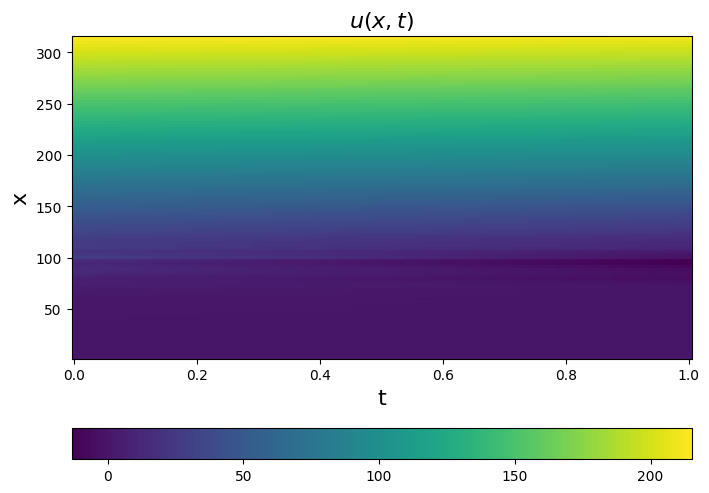

In [216]:
#Looking for the quality of interpolation
interpolation_method = 'Rbf'

n_time_points = 110
n_space_points =  110

interpol_u,ti,xi = rbf_interpolation(subsampled_u,subsampled_t,subsampled_x,n_time_points,n_space_points)

xi = xi[:,0]
ti = ti[0,:]
Xi, Ti = np.meshgrid(xi, ti)
XTi = np.asarray([Xi, Ti]).T

# Plot u and u_dot
plt.figure(figsize=(8, 6))
plt.pcolormesh(ti, xi, interpol_u)
# plt.plot(xi,ti)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
plt.title(r"$u(x, t)$", fontsize=16)
plt.colorbar(orientation="horizontal")

#Error rate, interpoalte only in known points
interpol_u_test,_,_ = interpol_dict[interpolation_method](subsampled_u,subsampled_t,subsampled_x,n_time_points,n_space_points)
rse, rmse = calc_error(interpol_u_test,u)

In [ ]:

def iter_psdn(u,
            lib,
            sigma_estimate,
            A,
            max_iter=10,
            alpha=.1,
            center_Theta=False,
            check_diverge=False):
    """Perform projection-based denoising.

    Args:
        u (d X N np.array): description
        lib: Library object to construct the Theta matrix
        sigma_estimate (d np.array):
        A ():
        max_iter (int):
        alpha (float in [0,1]):

    Returns:
        type: description


    """
    N = np.size(u, 1)
    m = np.size(u, 0)
    u_proj = np.copy(u)
    u_err_vec = []
    sigma_vec = []
    sum_vec = []

    for i in range(max_iter):

        Theta_temp = lib.fit_transform(u_proj)
        if center_Theta:
            Theta_temp = mlu.center_Theta(Theta_temp, d, m,
                                            sigma_estimate[0]**2)

        Phi = A @ Theta_temp
        print(A.shape)
        print(Theta_temp.shape)
        print(Phi.shape)
        Phi = np.hstack((np.ones(u), Phi))

        # Use SVD to perform projeciton
        U = la.svd(Phi, full_matrices=False)[0]
        P_Phi = U @ U.T
        u_proj_new = alpha * (P_Phi @ u_proj.T).T + (1 - alpha) * u_proj

        # Record mean of error
        sum_vec.append(1 / np.sqrt(N) * np.sum(u_proj_new - u, axis=1))

        # Record variance history
        sigma_pred = 1 / np.sqrt(N) * la.norm(u_proj_new - u, axis=1)
        sigma_vec.append(sigma_pred)

        # Check for divergence and break if sigma_pred is too large
        if check_diverge:
            update = (sigma_pred < sigma_estimate)
            if sum(update) == 0:
                print('WARNING: HIT MAX SIGMA')
                break
            # If varaince too large don't perform projection
            u_proj_new[update == 0, :] = u_proj[update == 0, :]

        n = np.min((np.size(u_proj_new, 1), np.size(u_proj, 1)))
        true_norm = la.norm(u_proj_new[:, :n], axis=1)
        conv_norm = la.norm(u_proj_new[:, :n] - u_proj[:, :n], axis=1) / true_norm

        if np.max(conv_norm) < 1e-8:

            print('Converged.')
            break

        u_proj = np.copy(u_proj_new)

    return u_proj, la.cond(Phi)



In [ ]:
A = get_discrete_integral_matrix(t)

In [ ]:
result_array = np.empty((110, 110, 1))

# Perform matrix multiplication for each dimension d
for i in range(1):
    result_array[:, :, i] = A @ u[:, :, i].T

# The result_array will have dimensions (n, n, d)
print(result_array.shape)

SyntaxError: invalid syntax (1241422748.py, line 8)

In [ ]:

library_functions = [lambda x: x, lambda x: x * x,lambda x: X.T,lambda x: X.T**2]
library_function_names = [lambda x: x,lambda x: x + '*' + x,lambda x: 'x',lambda x: 'x**2']


pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    include_interaction = False,
    derivative_order=2,
    spatial_grid=x,
    include_bias=False,
    is_uniform=True,
    periodic=False # uniformly sampled in time
)

iter_psdn(interpol_u.reshape((110,110,1)),
            pde_lib,
            None,
            A,
)

ValueError: cannot reshape array of size 121000 into shape (110,110,1)

In [214]:
# interpol_u_x = ps.FiniteDifference(axis=0,order = 2)._differentiate(interpol_u,t = xi)
# interpol_u_xx = ps.FiniteDifference(axis=0,d=2,order = 2)._differentiate(interpol_u,t = xi)
interpol_u_t = ps.FiniteDifference(axis=1,order = 2)._differentiate(interpol_u,t = ti)

interpol_u_ = np.ravel(interpol_u[random_rows,np.linspace(0,timesteps-1,timesteps,dtype=int)])
interpol_u_x_ = np.ravel(interpol_u_x[random_rows,np.linspace(0,timesteps-1,timesteps,dtype=int)])
interpol_u_xx_ =  np.ravel(interpol_u_xx[random_rows, np.linspace(0,timesteps-1,timesteps,dtype=int)])
interpol_u_t_ =  np.ravel(interpol_u_t[random_rows,np.linspace(0,timesteps-1,timesteps,dtype=int)])

_u =  np.ravel(u[:,:,0][random_rows, np.linspace(0,timesteps-1,timesteps,dtype=int)])
_u_x =  np.ravel(u_x[random_rows,np.linspace(0,timesteps-1,timesteps,dtype=int)])
_u_xx =  np.ravel(u_xx[random_rows, np.linspace(0,timesteps-1,timesteps,dtype=int)])
flatten_u_t =  np.ravel(u_t_[random_rows,np.linspace(0,timesteps-1,timesteps,dtype=int),0])


try: #In case we interpolate for a bigger grid than the original supress the error
    print('Derivative approx through interpolation general error:')

    print('error u_x:',np.linalg.norm(interpol_u_x - u_x)/np.linalg.norm(u_x))
    print('error u_xx:',np.linalg.norm(interpol_u_xx - u_xx)/np.linalg.norm(u_xx))
    print('error u_t:',np.linalg.norm(interpol_u_t - u_t_[:,:,0])/np.linalg.norm(u_t_[:,:,0]))
except:
    print('Unmatched grid')
    pass

print('\n')


print('Derivative approx through interpolation sample error:')

print('error u_x:',np.linalg.norm(interpol_u_x_ - _u_x)/np.linalg.norm(_u_x))
print('error u_xx:',np.linalg.norm(interpol_u_xx_ - _u_xx)/np.linalg.norm(_u_xx))
print('error u_t:',np.linalg.norm(interpol_u_t_ - flatten_u_t)/np.linalg.norm(flatten_u_t))

Derivative approx through interpolation general error:
error u_x: 0.8185612943065279
error u_xx: 76.59119309825816
error u_t: 0.4669644618038474


Derivative approx through interpolation sample error:
error u_x: 0.7551420561485268
error u_xx: 79.71735016184084
error u_t: 0.6777715419491132


In [ ]:
interpol_lib = np.vstack((interpol_u_,interpol_u_x_,interpol_u_xx_,x[random_rows],x[random_rows]**2)).T

dic_var = {'x0':'u','x1':'u_x', 'x2':'u_xx','x3':'x','x4':'x^2'}
library_functions = [lambda x: x,lambda x,y: x*y]
library_function_names = [lambda x: dic_var[x],lambda x,y: dic_var[x] + '*' + dic_var[y]]

lib = ps.CustomLibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    include_bias=False
)
fit_lib = lib.fit_transform(interpol_lib)


In [ ]:

print('------------Finite Difference------------')
optimizer = ps.STLSQ(threshold=1e-3, alpha=1e0)

model = ps.SINDy(feature_library=lib, optimizer=optimizer)


model.fit(interpol_lib,x_dot = interpol_u_t_)
model.print()

print('Error Model prediction against analytical solution:')
pred = model.predict(interpol_lib)
print('R2',model.score(x = interpol_lib,x_dot = flatten_u_t))
print('RSE',np.sum((pred.flatten() - flatten_u_t)**2)/np.sum((flatten_u_t - flatten_u_t.mean())**2))
print('RMSE',(np.sqrt(np.sum((pred.flatten() - flatten_u_t)**2))).mean())

print('\nMean threshold remove \n')
#Remove less participative terms
new_coef = threshold_remove(fit_lib,model.coefficients()[0],threshold = 0.05,axis=1,target = flatten_u_t)
pred = fit_lib @ new_coef
print_model(new_coef,lib.get_feature_names())
print('Error Model prediction against analytical solution:')
print('RSE',np.sum((pred.flatten() - flatten_u_t)**2)/np.sum((flatten_u_t - flatten_u_t.mean())**2))
print('RMSE',(np.sqrt(np.sum((pred.flatten() - flatten_u_t)**2))).mean())



------------Finite Difference------------
(x0)' = 2.955 u + 0.118 u*x + -0.009 u*x^2 + -2.901 u_x*x + 0.084 u_x*x^2 + -0.001 u_xx*x^2
Error Model prediction against analytical solution:
R2 -1.353136150723266
RSE 2.353136150723266
RMSE 84.31064694187619

Mean threshold remove 

(110, 15)
u_t = + -851.2 u + 229.06 u*x + -6.06 u*x^2 + 183.03 u_x*x + -7.31 u_x*x^2
Error Model prediction against analytical solution:
RSE 1.6163994681921343
RMSE 69.8768378112055


In [ ]:

print('----------------------------Ensemble method----------------------------')
optimizer = ps.STLSQ(threshold=1e-2, alpha=5e2)
# optimizer = ps.SR3(threshold=0.01,nu = .1 , max_iter=1000, tol=1e-10,thresholder='l0')
# optimizer = ps.SSR(alpha=.1,kappa = .001,)

model = ps.SINDy(feature_library=lib, optimizer=optimizer)
model.fit(interpol_lib, x_dot = interpol_u_t_,
        library_ensemble =False,
        ensemble = True,
        n_candidates_to_drop=4,
        n_models = 300,
        quiet=True)
library_ensemble_coefs = model.coef_list

mean_ensemble = np.mean(library_ensemble_coefs,axis=0)[0]
median_ensemble = np.median(library_ensemble_coefs,axis=0)[0]

print('Mean:')
print_model(mean_ensemble,lib.get_feature_names(),precision=3)
print('Median:')
print_model(median_ensemble,lib.get_feature_names(),precision=3)
#Fit the data using ensemble methos on the finite difference values

print('Error Model prediction against analytical solution:')
pred = model.predict(interpol_lib)
print('R2',model.score(x = interpol_lib,x_dot = flatten_u_t))
print('RSE',np.sum((pred.flatten() - flatten_u_t)**2)/np.sum((flatten_u_t - flatten_u_t.mean())**2))
print('RMSE',(np.sqrt(np.sum((pred.flatten() - flatten_u_t)**2))).mean())

print('\nMean threshold remove \n')
#Remove less participative terms
new_coef = threshold_remove(fit_lib,median_ensemble,threshold = 0.05,axis=1,target = flatten_u_t)
pred = fit_lib @ new_coef
print_model(new_coef,lib.get_feature_names())
print('Error Model prediction against analytical solution:')
print('RSE',np.sum((pred.flatten() - flatten_u_t)**2)/np.sum((flatten_u_t - flatten_u_t.mean())**2))
print('RMSE',(np.sqrt(np.sum((pred.flatten() - flatten_u_t)**2))).mean())



----------------------------Ensemble method----------------------------
Mean:
u_t = + -0.074 u + -0.094 x + 0.216 u*u_x + -0.0 u*u_xx + -0.014 u_x*x + 0.01 u_xx*x
Median:
u_t = + -0.074 u + -0.093 x + 0.213 u*u_x + -0.014 u_x*x
Error Model prediction against analytical solution:
R2 0.6584854905735426
RSE 0.34151450942645745
RMSE 26.19199068101222

Mean threshold remove 

(110, 15)
u_t = + -0.37 u + -0.06 x + 0.51 u*u_x + -0.04 u_x*x
Error Model prediction against analytical solution:
RSE 0.3275584836110865
RMSE 25.651239387025417


In [ ]:
print('-'*100)

interpol_u_ = interpol_u_.reshape(interpol_u_.shape[0],interpol_u_.shape[1],1)

optimizer = ps.STLSQ(threshold=1e-3, alpha=1e0)

print('------------Finite Difference------------')
#Fit the data using the finite difference approximation
library_functions = [lambda x: x, lambda x: x * x,lambda x: Xi.T,lambda x: Xi.T**2]
library_function_names = [lambda x: x,lambda x: x + '*' + x,lambda x: 'x',lambda x: 'x**2']

pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    include_interaction = True,
    derivative_order=2,
    spatial_grid=xi,
    include_bias=False,
    is_uniform=False,
    periodic=False # uniformly sampled in time
)
model = ps.SINDy(feature_names = ['u'],feature_library=pde_lib, optimizer=optimizer)


model.fit(interpol_u_)
model.print()
# print('Approximation error for real u:',model.score(u))
print('------------Weak Formulation------------')

optimizer = ps.STLSQ(threshold=1e-2, alpha=8e1)

library_functions = [lambda x: x, lambda x: x * x,lambda x: Xi.T,lambda x: Xi.T**2]
library_function_names = [lambda x: x,lambda x: x + '*' + x,lambda x: 'x',lambda x: 'x**2']

weak_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatiotemporal_grid=XTi,
    is_uniform=False,
    K=500,
)
model = ps.SINDy(feature_names = ['u'],feature_library=weak_lib, optimizer=optimizer)
model.fit(interpol_u_)
model.print()
# print('Approximation error for real u:',model.score(u))
print()

print('------------Ensemble------------')
optimizer = ps.STLSQ(threshold=1e-2, alpha=8e1)
# optimizer = ps.SR3(threshold=0.01,nu = .1 , max_iter=1000, tol=1e-10,thresholder='l0')
# optimizer = ps.SSR(alpha=.1,kappa = .001,)

model = ps.SINDy(feature_names = ['u'],feature_library=weak_lib, optimizer=optimizer)
model.fit(interpol_u_,
        library_ensemble =True,
        ensemble = True,
        n_candidates_to_drop=3,
        n_models = 300,
        n_subset = len(t),
        quiet=True)
library_ensemble_coefs = model.coef_list

mean_ensemble = np.mean(library_ensemble_coefs,axis=0)[0]
median_ensemble = np.median(library_ensemble_coefs,axis=0)[0]

print_model(mean_ensemble,lib.get_feature_names(),precision=3)
print_model(median_ensemble,lib.get_feature_names(),precision=3)
print()
# print('Approximation error for real u:',model.score(u))


print('-'*100)


----------------------------------------------------------------------------------------------------


IndexError: tuple index out of range